In [1]:
import os
import sys
import uproot
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")

from processing import kinematics
from ttbar_reconstruction import neutrino_four_momentum, four_momentum

%load_ext autoreload
%autoreload 2

In [2]:
base_path = "../reconstructions/SM_spin-ON_100k"
reco_names = [
    "p_top", "p_l_t", "p_b_t", "p_nu_t",
    "p_tbar", "p_l_tbar", "p_b_tbar", "p_nu_tbar", "idx", "weight"
]
batches = {name: [] for name in reco_names}

for batch_idx in range(10):
    for name in reco_names:
        batches[name].append(np.load(os.path.join(base_path, f"{name}_batch_{batch_idx}.npy")))

arrays = {name: np.concatenate(batches, axis=0) for name, batches in batches.items()}

idx_mask = arrays["idx"].reshape(-1)

In [3]:
events_path = "../mg5_data/SM-process_spin-ON_100k/Events/run_01_decayed_1/tag_1_delphes_events.root"
events = uproot.open(events_path)["Delphes"]

## Neutrinos

In [4]:
nu_e_t_mask = (
    (events["Particle.PID"].array() == 12) * (events["Particle.Status"].array() == 1)
)
nu_mu_t_mask = (
    (events["Particle.PID"].array() == 14) * (events["Particle.Status"].array() == 1)
)
nu_e_tbar_mask = (
    (events["Particle.PID"].array() == -12) * (events["Particle.Status"].array() == 1)
)
nu_mu_tbar_mask = (
    (events["Particle.PID"].array() == -14) * (events["Particle.Status"].array() == 1)
)
nu_mask = nu_e_t_mask + nu_mu_t_mask + nu_e_tbar_mask + nu_mu_tbar_mask

px = events["Particle.Px"].array()[nu_mask][idx_mask].flatten()
py = events["Particle.Py"].array()[nu_mask][idx_mask].flatten()
pz = events["Particle.Pz"].array()[nu_mask][idx_mask].flatten()
E = events["Particle.E"].array()[nu_mask][idx_mask].flatten()

phi = events["Particle.Phi"].array()[nu_mask][idx_mask].flatten()
eta = events["Particle.Eta"].array()[nu_mask][idx_mask].flatten()

In [5]:
p_true = np.stack([px, py, pz, E], axis=1)
p_calc = np.stack(
    [neutrino_four_momentum(px=px[idx], py=py[idx], eta=eta[idx]) for idx in range(len(px))],
    axis=0
)

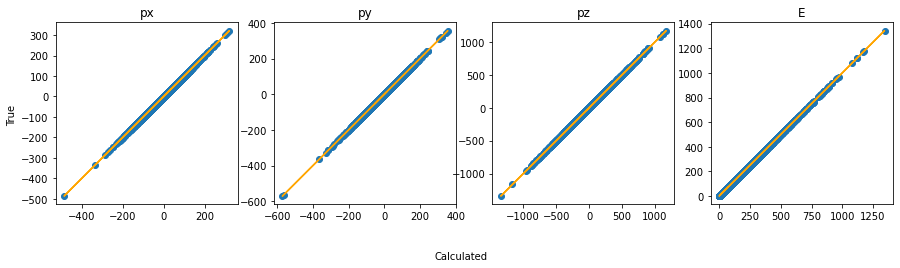

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 8))

idx_to_label = {0: "px", 1: "py", 2: "pz", 3: "E"}

for idx in range(p_calc.shape[1]):
    ax[idx].scatter(p_calc[:, idx], p_true[:, idx])
    ax[idx].plot(p_true[:, idx], p_true[:, idx], color="orange", label="Perfect ")
    ax[idx].set_aspect('equal', 'box')
    ax[idx].set_title(idx_to_label[idx])
    
fig.text(0.5, 0.25, 'Calculated', ha='center')
fig.text(0.08, 0.5, 'True', va='center', rotation='vertical');

Text(0.5, 1.0, '$\\eta$ Differences - MAE: 1.982e-08')

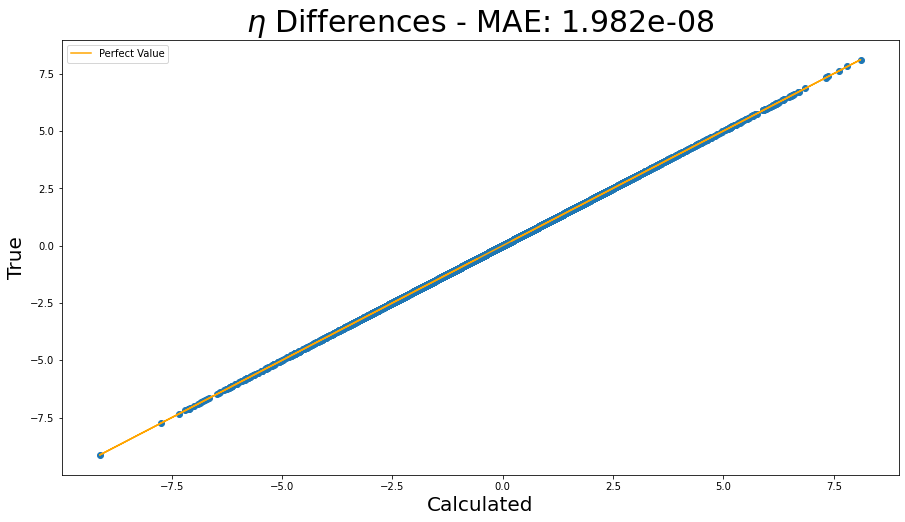

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))
eta_calc = kinematics.eta(p_calc)
plt.scatter(eta_calc, eta)
plt.plot(eta, eta, color="orange", label="Perfect Value")
plt.xlabel("Calculated", fontsize=20)
plt.ylabel("True", fontsize=20)
plt.legend()
eta_error = np.mean(np.abs(eta_calc - eta), axis=0)
plt.title(f"$\eta$ Differences - MAE: {eta_error:.3e}", fontsize=30)

Text(0.5, 1.0, '$\\phi$ Differences - MAE: 3.618e-08')

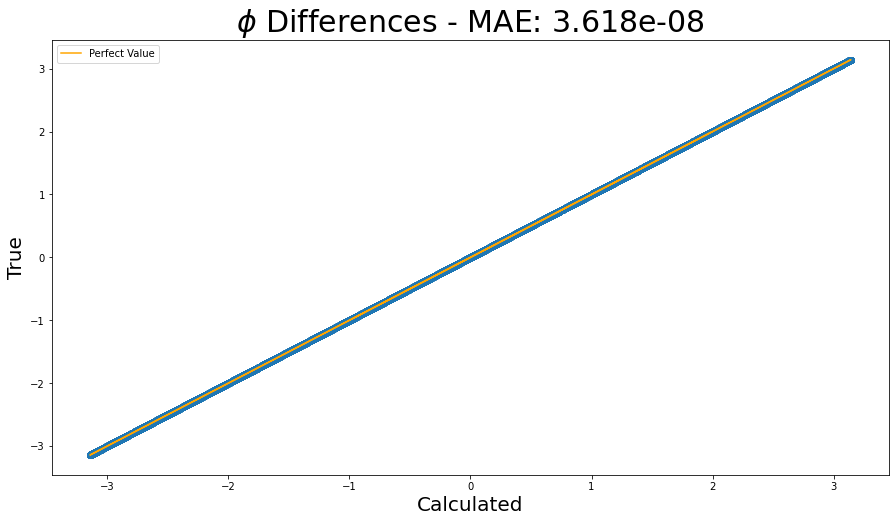

In [8]:
fig, ax = plt.subplots(figsize=(15, 8))
phi_calc = kinematics.phi(p_calc)
plt.scatter(phi_calc, phi)
plt.plot(phi, phi, color="orange", label="Perfect Value")
plt.xlabel("Calculated", fontsize=20)
plt.ylabel("True", fontsize=20)
plt.legend()
phi_error = np.mean(np.abs(phi_calc - phi), axis=0)
plt.title(f"$\phi$ Differences - MAE: {phi_error:.3e}", fontsize=30)

In [30]:
dR = kinematics.dR(p_true, p_calc)
clean_mask = ~np.isclose(dR, 10e10)
dR = dR[clean_mask]
print(f"dR Max: {dR.max()}")
print(f"dR mean: {dR.mean()}")
print(f"dR std: {dR.std()}")

dR Max: 0.1255560263801261
dR mean: 2.804840505858262e-05
dR std: 0.0010892638972019254
